# Neural Networks (NN)

### Pre-requisites

Similarly to our previous notebooks, the following modules and/or packages are required. These have been previously explained in related notebooks.

In [1]:
from tensorflow.python.eager.context import get_config
from tensorflow import keras 
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Masking, Embedding

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Masking, Embedding

# from keras import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.utils.vis_utils import plot_model
import pydot
import graphviz

In [2]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize

from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem import WordNetLemmatizer, SnowballStemmer
## nltk.download('stopwords')
## nltk.download('punkt')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn import metrics

from word2number import w2n
import string
import re

from time import time
import pickle
import os

import random
from random import sample

We change the work directory accordingly to where our data from the previous analysis was stored.

In [3]:
os.chdir("D://Datasets//Various Datasets")

We now load the files (and close them!) using pickles. The 3 variables will contain:
- 'data' : The lyrics, pre-processed and cleaned

- 'seq' : The lyrics, sequentially transformed. Loading this is optional, since we transform them any way.

- 'genre' : The target variable, i.e. the genres to be predicted

In [181]:
file_1 = open('lyrics.sav', 'rb')
file_2 = open('sequences.sav', 'rb')
file_3 = open('Target.sav', 'rb')

data = pickle.load(file_1)
seq = pickle.load(file_2)
genre = pickle.load(file_3)

file_1.close()
file_2.close()
file_3.close()

## Recurrent Neural Net - RNN

The first approach to NN implementation we take is using bidirectional, dynamic networks with the ability to back-and-forth propagate information - known as recurrent neural networks (RNN). The main advantage of such graphs is that information is perpetually improved, as well as preserved to earlier states depending on epoch, by retaining memory of the epochs in a local log. 


Unlike other NNs like Word2Vec, or techniques such as skip-grams or N-grams, RNNs do not rely on contextual analysis: which would be unsuitable for song analysis, as they do not respect context or circumstances, unlike books or novels. Therefore, a more simple approach is preferred in these situations, as long as we find a way to reliable transform data into a numerical format.

First, let's look at whether the data has translated correctly:

In [182]:
len(data)

79452

First, we set out threshold to the number of words we want to consider from a song. We might not be interested in songs with fewer than 40 words, for example. Let's set an initial expectation at 100:

In [183]:
threshold=100

We then initialize the tokenizer from keras. This will be necessary, despite having already tokenized the lyrics, so we can fit it in order to perform sequentialization of the data: i.e. getting words to numbers.

In [184]:
tokenizer = Tokenizer(
    num_words=None,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True, split=' ')

We now fit it on the entire data:

In [185]:
tokenizer.fit_on_texts(data)

Now we can define the sequences. This is identical to our 'seq' variable that we have imported.

In [186]:
sequences = tokenizer.texts_to_sequences(data)

We create the dataset by binding together the sequences, lyrics and genres:

In [187]:
data = pd.concat([pd.Series(data), genre, pd.Series(sequences)], axis=1)
data.columns = ['Lyrics', 'Genre', 'Numeric_lyrics']

We now split the data into our usual train/test split:

In [188]:
X = data['Lyrics']
y = data['Genre']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 124, stratify=y)

Lastly, we should transform the train and test accordingly instead:

In [189]:
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
sequences_train[0][:15]

[377, 13, 18, 63, 620, 213, 1486, 26, 147, 554, 399, 213, 16, 159, 12]

We save the indices from the entire data (i.e. those fit on both train+test together), so we can re-trace their marking on the lyrics (using only the resulting numbers)

In [190]:
idx_word = tokenizer.index_word

' '.join(idx_word[w] for w in sequences_train[0][:15])

'sorri babi take hand wing alright haha look sun search moon alright say fli yeah'

Now: One issue we encounter is that not all songs have the same length, i.e. number of words. However, what we can feasibly look at is a set threshold for the minimum number of words to compare against. Therefore, we start by looking at the number of words for each of our 2 splits:

In [191]:
train_len = [len(x) for x in sequences_train]
test_len = [len(x) for x in sequences_test]

y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)
y_train.columns = ['Genre']
y_test.columns = ['Genre']

In [192]:
y_train['ind'] = np.where(pd.Series(train_len)>=threshold, 1, 0)
y_test['ind'] = np.where(pd.Series(test_len)>=threshold, 1, 0)

In [193]:
target_train = y_train['Genre'].loc[y_train['ind']==1].reset_index(drop=True)
target_test = y_test['Genre'].loc[y_test['ind']==1].reset_index(drop=True)

In [194]:
target_train.head()

0    0
1    2
2    0
3    0
4    2
Name: Genre, dtype: int64

Based on the findings, we decide to set an initial threshold of 100:

In [195]:
sequences_train = [seq for seq in sequences_train if len(seq)>=threshold]
sequences_test = [seq for seq in sequences_test if len(seq)>=threshold]

sequences_train = [seq[:threshold] for seq in sequences_train]
sequences_test = [seq[:threshold] for seq in sequences_test]

We now construct the model architecture-wise. Crucially, the first layer is an LSTM layer - which is commonly used in text predictive/classification oriented NNs.

In [196]:
model = Sequential()

model.add(LSTM(64, activation='relu',
               input_shape=(threshold,1), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='relu'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

We may now take a look at the model summary.

In [197]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 100, 64)           16896     
                                                                 
 dropout_21 (Dropout)        (None, 100, 64)           0         
                                                                 
 lstm_15 (LSTM)              (None, 64)                33024     
                                                                 
 dropout_22 (Dropout)        (None, 64)                0         
                                                                 
 dense_14 (Dense)            (None, 32)                2080      
                                                                 
 dropout_23 (Dropout)        (None, 32)                0         
                                                                 
 dense_15 (Dense)            (None, 1)                

We now need to fit our data. However, we would need to get it into a format accepted by the tf-keras framework. Firstly, the lists need translating to series:

In [198]:
X_train = pd.Series(sequences_train)
X_test = pd.Series(sequences_test)

y_train = target_train.copy()
y_test = target_test.copy()

Let's check the outcome:

In [199]:
X_train.head()

0    [34, 136, 1004, 45, 136, 192, 384, 616, 112, 8...
1    [431, 658, 264, 79, 79, 377, 56, 551, 74, 204,...
2    [11, 48, 40, 174, 174, 11, 11, 1355, 776, 1355...
3    [1304, 29, 23, 1579, 156, 1333, 345, 28, 86, 1...
4    [50, 16264, 39, 1834, 97, 89, 2, 20, 86, 11, 2...
dtype: object

We perform a quick match between our splits, to ensure we retained the correct dimensions:

In [200]:
print(f'Sanity test outcome for training: {y_train.shape == X_train.shape}')
print(f'Sanity test outcome for testing: {y_test.shape == X_test.shape}')

Sanity test outcome for training: True
Sanity test outcome for testing: True


Then, we transform the lists output above into a readable format for the NN - by translating them into columns for a dataframe. We add them together to construct the necessary 'final' testing and training sets respectively.

In [203]:
for i in range(threshold):
    globals()['X_good_{}'.format(i)] = [int(X_train[j][i]) for j in range(len(X_train))]
    globals()['X_bad_{}'.format(i)] = [int(X_test[j][i]) for j in range(len(X_test))]

In [204]:
X_final_train = pd.concat([pd.Series(globals()['X_good_{}'.format(i)]) for i in range(threshold)], axis=1)
X_final_test = pd.concat([pd.Series(globals()['X_bad_{}'.format(i)]) for i in range(threshold)], axis=1)

We are now prepared fit the model:

In [205]:
history = model.fit(X_final_train,y_train,epochs=5, validation_data=(X_final_test,y_test))

Epoch 1/5
1056/1056 [==============================] - 103s 95ms/step - loss: 5.1467 - accuracy: 0.3091 - val_loss: 2.5913 - val_accuracy: 0.2631
Epoch 2/5
1056/1056 [==============================] - 106s 100ms/step - loss: 3.2820 - accuracy: 0.2820 - val_loss: 1.6029 - val_accuracy: 0.2578
Epoch 3/5
1056/1056 [==============================] - 114s 108ms/step - loss: 2.7585 - accuracy: 0.2727 - val_loss: 1.5956 - val_accuracy: 0.2579
Epoch 4/5
1056/1056 [==============================] - 112s 106ms/step - loss: 2.6386 - accuracy: 0.2722 - val_loss: 1.5956 - val_accuracy: 0.2579
Epoch 5/5
1056/1056 [==============================] - 113s 107ms/step - loss: 2.4313 - accuracy: 0.2694 - val_loss: 1.6029 - val_accuracy: 0.2578


We can notice that, from one epoch to the other, the loss decreases - indicating a trend of progressive learning. However, the primary evaluation accuracies decrease as well, leading to very similar overall accuracies in the end. There are many steps that could be tried given these tendencies: first of all, providing more data. Clearly, the information gain of the RNN is weak to the point that architectural choice wouldn't notably infleunce the outcome.

Nevertheless, results from this model seem to be underwhelming, as a result of deep recursive learning of noisy data. Therefore, it is preferable we take an alternate - and more basic - approach to the problem.

## Simple MLP (Multi Layer Perceptron)

Perhaps somewhat counterintuitively, previous approaches seem to indicate that we might have better success by using less powerful tools, but more cleverly. The most basic type of neural networks is an SLP (Single Layer Perceptron), which is made of only one input, one ouput and a single hidden layer in between.

An MLP simply adds more hidden layers to the process, with the option to drawback on a simple SLP by implicit architecture choice. This offers a wider range of hyper-parameter tuning potential, as well as more flexibility. Let's start by setting a threshold for the # of words selected from sequences, just like we did for RNN:

In [206]:
threshold=200

We will then define our feature+target based on the threshold. 

In [207]:
## Get the initial data as uploaded
X = seq
y = genre

## Select only data with more than threshold words per song
X_good = X[X.str.len()>threshold]
idx = X_good.index
y = y[y.index.isin(idx)].copy() ## Set the target to match our selection

## Reset the index to avoid extra, unwanted column
X_good = X_good.reset_index(drop=True)
y = y.reset_index(drop=True)

We now need to bind the words into singular values, bu column. To do that, we transform them into columns 1 by 1 rather than an array, to create M features for the task where M = threshold chosen.

In [208]:
for i in range(threshold):
    globals()['X_good_{}'.format(i)] = [int(X_good[j][i]) for j in range(len(X_good))]

We then transform them all into series, so they can later be combined into a single dataframe

In [209]:
for i in range(threshold):
    globals()['X_good_{}'.format(i)] = pd.Series(globals()['X_good_{}'.format(i)])

Output a sample of our methods:

In [210]:
X_good_0.head()

0    39991
1      966
2        5
3       49
4      372
dtype: int64

We can now concatenate them into the final data:

In [211]:
X_final = pd.concat([globals()['X_good_{}'.format(i)] for i in range(threshold)], axis=1)

In [212]:
X_final.shape

(11088, 200)

Lastly, check that the shape of the target matches our expectations before performing our split.

In [213]:
y.shape

(11088,)

Perform the train/test split

In [214]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size = 0.2, random_state = 124, stratify=y)

Finally, we define our MLP model with the chosen architecture, and fit our data on it:

In [215]:
clf = MLPClassifier(random_state=1, max_iter=300, activation='relu', learning_rate='adaptive',
                   hidden_layer_sizes=(15,10,6,3,3,6,10,15)).fit(X_train, y_train)

We output the accuracy score.

In [216]:
clf.score(X_test, y_test)

0.7091974752028855

This falls short off our expectations for using it as a general model. At this level of performance, we would not be justified in considering a NN approach (either RNN or simple MLP) as opposed to the more basic vectorized logistic regression. However, this can be explained by considering what happens at each input of new word thresholds from songs. It is likely that performance will keep increasing with data at an exponential rate once the NN achieves its learning balance.

To test this hypothesis, we will perform a self-built grid search which re-initializes the entire procedure with a free choice of hyperparameters. We will pay particular consideration to how different activation functions perform on the given task.

Let's deploy some empty lists/arrays where we will store our findings:

In [217]:
relu=[]
tan=[]
logi=[]

We now define the gridsearch accordingly:

In [218]:
def GridSearchNN(threshold, activ='relu', max_iter=200, hid=(15,10,6,3,3,6,10,15)):
    ''' We initialize the data just like before, the only change being the threshold that can now be pre-set '''
    
    ## Get and combine the data
    X = seq
    y = genre
    X_good = X[X.str.len()>threshold]
    idx = X_good.index
    y = y[y.index.isin(idx)].copy()

    X_good = X_good.reset_index(drop=True)
    y = y.reset_index(drop=True)
    
    ## Perform the datapoints binding 
    for i in range(threshold):
        globals()['X_good_{}'.format(i)] = [X_good[j][i] for j in range(len(X_good))]
    for i in range(threshold):
        globals()['X_good_{}'.format(i)] = pd.Series(globals()['X_good_{}'.format(i)])
    
    ## Combine the resulting columns in a format accepted by the model
    X_final = pd.concat([globals()['X_good_{}'.format(i)] for i in range(threshold)], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size = 0.2, random_state = 124, stratify=y)
    
    ## Perform prediction
    clf = MLPClassifier(random_state=1, max_iter=max_iter, activation=activ, hidden_layer_sizes=hid).fit(X_train, y_train)
    score = round(clf.score(X_test, y_test)*100, 4)
    print(f"For threshold: {threshold} ~~~~~ Activation: {activ} ~~~~~~~\
    Iterations: {max_iter} ~~~~~~~ Score: {score}")
    
    ## Append the resulting accuracy scores for each 
    ## activation function to their respective list
    if(activ=='relu'):
        relu.append(score)
    elif(activ=='logistic'):
        logi.append(score)
    else:
        tan.append(score)

All that's left now is to apply the GridSearch on several parameters of our choice. Most importantly, we will test the NN across various thresholds, i.e. words per song. The expected result is that it will initially have _some_ performance, that will keep dropping as it gets to see more words which add unprecedented variety - and this trend might continue until the learning rate will be able to catch up to it; i.e. when words start repeating sufficiently for the NN to pick it up as signal.

We will of course also monitor performance across our 3 main activation functions. Off-record, a large number of other properties were tested as well, including maximum iterations permitted, learning rate, architecture as well as randomness. Neither of these exhibited particular propensities one way or the other for us to delve deeper into. Therefore, we will run a slightly less complicated grid-search this time:

In [219]:
thresh = [1,5,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,170,180,190,200,210,220,230,240,250,260,270,280,290,300,
         310,320,330,340,350,360,370,380,390,400] ## Set threshold markers
activ = ['logistic', 'relu', 'tanh'] ## Set activation function markers
for item in thresh:
    for act in activ:
        GridSearchNN(item, activ=act, max_iter=200) ## Perform the search iteratively and output findings

For threshold: 1 ~~~~~ Activation: logistic ~~~~~~~    Iterations: 200 ~~~~~~~ Score: 58.0621
For threshold: 1 ~~~~~ Activation: relu ~~~~~~~    Iterations: 200 ~~~~~~~ Score: 58.3517
For threshold: 1 ~~~~~ Activation: tanh ~~~~~~~    Iterations: 200 ~~~~~~~ Score: 58.0621
For threshold: 5 ~~~~~ Activation: logistic ~~~~~~~    Iterations: 200 ~~~~~~~ Score: 58.0334
For threshold: 5 ~~~~~ Activation: relu ~~~~~~~    Iterations: 200 ~~~~~~~ Score: 58.0334
For threshold: 5 ~~~~~ Activation: tanh ~~~~~~~    Iterations: 200 ~~~~~~~ Score: 58.0334
For threshold: 10 ~~~~~ Activation: logistic ~~~~~~~    Iterations: 200 ~~~~~~~ Score: 58.0167
For threshold: 10 ~~~~~ Activation: relu ~~~~~~~    Iterations: 200 ~~~~~~~ Score: 58.023
For threshold: 10 ~~~~~ Activation: tanh ~~~~~~~    Iterations: 200 ~~~~~~~ Score: 58.0167
For threshold: 20 ~~~~~ Activation: logistic ~~~~~~~    Iterations: 200 ~~~~~~~ Score: 57.8834
For threshold: 20 ~~~~~ Activation: relu ~~~~~~~    Iterations: 200 ~~~~~~~ Score

For threshold: 290 ~~~~~ Activation: tanh ~~~~~~~    Iterations: 200 ~~~~~~~ Score: 88.4835
For threshold: 300 ~~~~~ Activation: logistic ~~~~~~~    Iterations: 200 ~~~~~~~ Score: 89.3671
For threshold: 300 ~~~~~ Activation: relu ~~~~~~~    Iterations: 200 ~~~~~~~ Score: 89.3671
For threshold: 300 ~~~~~ Activation: tanh ~~~~~~~    Iterations: 200 ~~~~~~~ Score: 89.3671
For threshold: 310 ~~~~~ Activation: logistic ~~~~~~~    Iterations: 200 ~~~~~~~ Score: 90.1146
For threshold: 310 ~~~~~ Activation: relu ~~~~~~~    Iterations: 200 ~~~~~~~ Score: 90.1146
For threshold: 310 ~~~~~ Activation: tanh ~~~~~~~    Iterations: 200 ~~~~~~~ Score: 90.1146
For threshold: 320 ~~~~~ Activation: logistic ~~~~~~~    Iterations: 200 ~~~~~~~ Score: 90.0958
For threshold: 320 ~~~~~ Activation: relu ~~~~~~~    Iterations: 200 ~~~~~~~ Score: 90.0958
For threshold: 320 ~~~~~ Activation: tanh ~~~~~~~    Iterations: 200 ~~~~~~~ Score: 90.0958
For threshold: 330 ~~~~~ Activation: logistic ~~~~~~~    Iterations:

D:\AnacondaIsHere\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


For threshold: 390 ~~~~~ Activation: tanh ~~~~~~~    Iterations: 200 ~~~~~~~ Score: 92.6531
For threshold: 400 ~~~~~ Activation: logistic ~~~~~~~    Iterations: 200 ~~~~~~~ Score: 92.5581
For threshold: 400 ~~~~~ Activation: relu ~~~~~~~    Iterations: 200 ~~~~~~~ Score: 92.5581
For threshold: 400 ~~~~~ Activation: tanh ~~~~~~~    Iterations: 200 ~~~~~~~ Score: 92.5581


We will perform a quick test that our results have been transcribed accordingly:

In [220]:
## Should evaluate to True
len(relu)==len(tan)==len(logi)==len(thresh)

True

We'll bind our results into a single dataframe so it can be plotted accordingly:

In [221]:
df = pd.concat([pd.Series(thresh), pd.Series(logi), pd.Series(tan), pd.Series(relu)], axis=1)
df.columns = ['X', 'Logit', 'Tan', 'Relu']

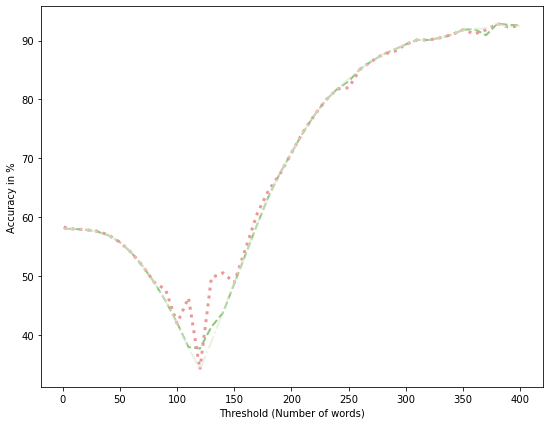

In [223]:
fig=plt.figure(figsize=(9,7))
ax=fig.add_subplot(111)
 

ax.plot(df.X,df.Tan,c='#93c47d',ls='--',label='Tan',linewidth=2.0)
ax.plot(df.X,df.Relu,c='#ea9999', ls=':',label='Relu',linewidth=3.0)
ax.plot(df.X, df.Logit, c = '#d9ead3',ls='-.',label='Logit',linewidth=2.0, alpha = 0.6)

ax.set_xlabel('Threshold (Number of words)')
ax.set_ylabel('Accuracy in %')
plt.show()

As expected, we encounter the aforementioned behaviour. The continuous drop is due to the new words from each song leading to a rapid dictionary expansion for which the network cannot account via its learning. Once the (dynamic) dictionary expansion slows down, based on the size of the static dictionary (i.e. the total pool of tokenized words available in our data), the NN begins to transform noise into signal exceptionally well, to the point of overfitting shortly after.

Therefore, we may deduce that there is a "desirable range", mostly 200-400, where our network performs at its best. We can build a strategy using an ensemble of our methods based on these findings in order to predict genres with as much accuracy as possible. You can find out more [here](https://www.mathcha.io/editor/4Qmgou4GfLpHld1wQoSWg9vYIGXngyxSlBw1GL) regarding the mathematical implications of the network's progress throughout the threshold markers.

Lastly, we may be interested in testing some extreme cases. The following solver paired with an adaptive learning rate is extremely thorough, which may initially led us to believe that it could potentially outperform our previous findings. However, we are to find out that it never truly converges, despite allowing a ridiculous amount of iterations to loop.

In [ ]:
## NOTE: Running locally ill-advised due to exceptional runtime.

# clf_long = MLPClassifier(random_state=1, max_iter=10**4, activation='logistic',\
#                        solver='lbfgs', learning_rate='adaptive').fit(X_train, y_train)

# clf_long.score(X_test, y_test)

The score obtained was nothing better than our previous findings. We recorded an accuracy of slightly below 71% on the chosen example.

What happens if we let the same algorithm run for an extremely short amount, ignoring its need to converge?

In [224]:
clf_short = MLPClassifier(random_state=1, max_iter=50, activation='logistic',\
                       solver='lbfgs', learning_rate='adaptive').fit(X_train, y_train)
clf_short.score(X_test, y_test)

D:\AnacondaIsHere\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


0.7069431920649234

Surprisingly, we lost very little accuracy as opposed to our previous algorithm. Indeed, it seems like the minimal performance gain does not justify running such a tedious algorithm, so it's best we retain our previous findings using the gridsearch.

We will now run the algorithm one last time, just to get a full picture of the optimal parameters for selection:

In [225]:
clf_layer = MLPClassifier(random_state=1, max_iter=200, activation='logistic',hidden_layer_sizes = (15,10,6,3,3,6,10,15),
                       solver='adam', learning_rate='invscaling').fit(X_train, y_train)

The parameters are:

In [226]:
clf_layer.get_params()

{'activation': 'logistic',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (15, 10, 6, 3, 3, 6, 10, 15),
 'learning_rate': 'invscaling',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 200,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': 1,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

We conclude this section with a summary of the (practical) MLP behaviour recorded on our best estimators. These findings finalize our project, as we are ready to develop a product based on an ensemble of the methods & models explored.

**MLP behaviour:** 

    - Underfits up until ~20 threshold. Expected accuracy 55-58% acc.

    - Performance drop until ~ 140 threshold. Drop up to 38-40% acc.
    
    - Performance steady increase until ~200 threshold. Expected accuracy of 75%. Becomes the **relevant algorithm**.
    
    - Performance spike until 250-260 threshold. Begins overfitting ~ 260 threshold. Acc keeps increasing, slowly.
    
    - Reach ~90% acc for threshold 300.
    
    - Despite overfit, accuracy also increases until 380-390 threshold up to ~92%, from which point it starts decreasing.
    
    - Reach global recorded minimum (on a steady decrease) of ~ 88% acc at threshold 500.

**References**   ~ * denotes personal work bearing author rights


[1. RNN pre-processing](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer)


[2. RNN implementation on NL](https://towardsdatascience.com/recurrent-neural-networks-by-example-in-python-ffd204f99470)


[3. CNN implementation](https://towardsdatascience.com/feed-forward-neural-networks-how-to-successfully-build-them-in-python-74503409d99a)


[4. MLP - NN with sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)


[5. How to interpret NN performance relative to data - a short mathematical guide](https://www.mathcha.io/editor/4Qmgou4GfLpHld1wQoSWg9vYIGXngyxSlBw1GL) *